In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Multilingual News Article Similarity/train modules

In [ ]:
!pip install -q accelerate==0.3.0
!pip install -q transformers==4.10.3
!pip install -q nlp==0.4.0
!pip install -q datasets==1.9.0
!pip install -q sentencepiece

In [ ]:
import numpy as np
import torch

import torch.nn as nn
import pandas as pd
import seaborn as sns

import transformers
import nlp
# from torch.utils.data import Dataset
from datasets import load_dataset, Dataset
import matplotlib.pyplot as plt
import logging
from sklearn.model_selection import train_test_split
logging.basicConfig(level=logging.INFO)

from transformers.modeling_outputs import SequenceClassifierOutput
from collections import defaultdict

import json
from tqdm.notebook import tqdm

tqdm.pandas()

In [ ]:
transformers.__version__

'4.10.3'

In [ ]:
transformers.logging.set_verbosity_error()

-----
## Previously trained files

-----
## Correlation Mapping
Finding the correlation between Entity, Narrative and Overall Similarity scores

In [ ]:
df = pd.read_csv("../dataset/final_data.csv", index_col='pair_id')
df.head(3)

,url1_lang,url2_lang,link1,link2,ia_link1,ia_link2,Geography,Entities,Time,Narrative,Overall,Style,Tone,text_a,text_b
pair_id,,,,,,,,,,,,,,,
1484084337_1484110209,en,en,https://www.washingtonpost.com/local/virginia-...,https://www.washingtonpost.com/world/the_ameri...,https://web.archive.org/web/www.washingtonpost...,https://web.archive.org/web/www.washingtonpost...,4.0,4.0,1.0,4.000000,4.000000,1.666667,2.000000,Police in West Virginia say a suspected drunke...,“Those who continue to get rich find it normal...
1484396422_1483924666,en,en,https://www.stlucianewsonline.com/guyana-three...,https://www.thestar.com/news/world/europe/2020...,https://web.archive.org/web/www.stlucianewsonl...,https://web.archive.org/web/www.thestar.com/ne...,4.0,4.0,1.0,4.000000,3.666667,1.666667,1.333333,Share This On: Pin 11 Shares (NEWS ROOM GUYANA...,Several witnesses reported that they had seen ...
1484698254_1483758694,en,en,https://www.teaparty.org/trump-brings-in-2020-...,https://www.timesofisrael.com/trump-says-he-do...,https://web.archive.org/web/www.teaparty.org/t...,https://web.archive.org/web/www.timesofisrael....,1.0,2.0,1.0,2.333333,2.333333,1.000000,1.333333,"So I’d rather have you be honorable, okay?” Wh...","“I don’t see that happening,” Trump said at hi..."


INFO:numexpr.utils:NumExpr defaulting to 8 threads.


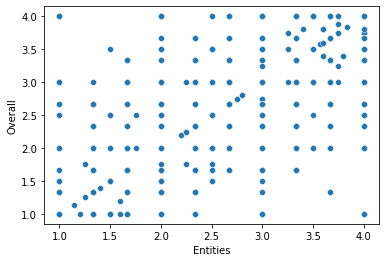

In [ ]:
sns.scatterplot(data=df, x="Entities", y="Overall")

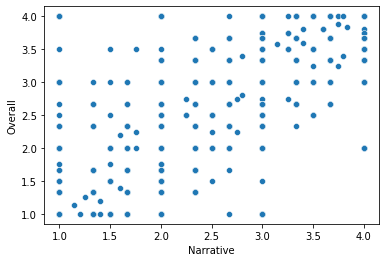

In [ ]:
sns.scatterplot(data=df, x="Narrative", y="Overall")

In [ ]:
from sklearn.neural_network import MLPRegressor
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.1)

In [ ]:
regr = MLPRegressor(random_state=1, max_iter=50000).fit(np.array(train_df['Entities']).reshape(-1, 1), np.array(train_df['Overall']).reshape(-1, 1))
pred = regr.predict(np.array(test_df['Entities']).reshape(-1, 1))

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
mean_squared_error(pred, np.array(test_df['Overall']))

0.3998433858515748

In [ ]:
pearsonr(pred, np.array(test_df['Overall']))

(0.8034343450751333, 1.8293437458376546e-93)

# Load Data

In [ ]:
# paths to semeval dataset
path_to_longform_textrank_data = "../dataset/semeval/multi-entity/"
path_to_train = f"{path_to_longform_textrank_data}train_ent_nar.csv"
path_to_test = f"{path_to_longform_textrank_data}test_ent_nar.csv"
path_to_validation = f"{path_to_longform_textrank_data}final_test_ent_narr.csv"

In [ ]:
dataset_dict = {
  "semeval": load_dataset('csv', data_files={
      'train': path_to_train,
      'validation': path_to_validation,
      'test': path_to_test,
  })
}

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-c99a88787697434f/0.0.0/e138af468cb14e747fb46a19c787ffcfa5170c821476d20d5304287ce12bbc23. Subsequent calls will reuse this data.


In [ ]:
dataset_dict

{'semeval': DatasetDict({
    train: Dataset({
        features: ['pair_id', 'entities', 'narrative', 'label', 'sentence1', 'sentence2', 'idx'],
        num_rows: 3663
    })
    validation: Dataset({
        features: ['pair_id', 'entities', 'narrative', 'label', 'sentence1', 'sentence2', 'idx'],
        num_rows: 4902
    })
    test: Dataset({
        features: ['pair_id', 'entities', 'narrative', 'label', 'sentence1', 'sentence2', 'idx'],
        num_rows: 408
    })
})}

We can show one example from each task.

In [ ]:
for task_name, dataset in dataset_dict.items():
    print(task_name)
    print(dataset_dict[task_name]["train"][0])
    print()

semeval
{'pair_id': '1484189574_1484212280', 'entities': 4.0, 'narrative': 4.0, 'label': 4.0, 'sentence1': 'Add data for Melbourne Do you live in Index Crime Index: 44.49 Safety Index: 55.51 Crime rates in Melbourne, Australia Level of crime 46.72 Moderate Crime increasing in the past 3 years 68.09 High Worries home broken and things stolen 42.54 Moderate Worries being mugged or robbed 39.09 Low Worries car stolen 34.58 Low Worries things from car stolen 40.82 Moderate Worries attacked 43.00 Moderate Worries being insulted 45.51 Moderate Worries being subject to a physical attack because of your skin colour, ethnic origin or religion 30.45 Low Problem people using or dealing drugs 55.52 Moderate Problem property crimes such as vandalism and theft 53.41 Moderate Problem violent crimes such as assault and armed robbery 46.07 Moderate Problem corruption and bribery 34.98 Low Safety in Melbourne, Australia Safety walking alone during daylight 73.92 High Safety walking alone during night 43

In [ ]:
device = 'cpu'

In [ ]:
class MultitaskModel(transformers.PreTrainedModel):
    def __init__(self, encoder, taskmodels_dict, in_dimension, hidden_size):
        """
        Setting MultitaskModel up as a PretrainedModel allows us
        to take better advantage of Trainer features
        """
        super().__init__(transformers.PretrainedConfig())

        self.encoder = encoder
        self.taskmodels_dict = nn.ModuleDict(taskmodels_dict)

        self.dense = nn.Linear(768, 512)
        self.dropout = nn.Dropout(0.5)
        self.out_proj = nn.Linear(512, 2)

    @classmethod
    def create(cls, model_name, model_type_dict, model_config_dict):
        """
        This creates a MultitaskModel using the model class and config objects
        from single-task models.
        We do this by creating each single-task model, and having them share
        the same encoder transformer.
        """
        shared_encoder = None
        taskmodels_dict = {}
        for task_name, model_type in model_type_dict.items():
            model = model_type.from_pretrained(
                model_name,
                config=model_config_dict[task_name],
                # device='cpu'
            )
            if shared_encoder is None:
                # shared_encoder = getattr(model, cls.get_encoder_attr_name(model))
                shared_encoder = "temp"
            else:
                setattr(model, cls.get_encoder_attr_name(model), shared_encoder)
            taskmodels_dict[task_name] = model
        return cls(encoder=shared_encoder, 
                   taskmodels_dict=taskmodels_dict,
                   in_dimension=768,
                   hidden_size=512)


    @classmethod
    def get_encoder_attr_name(cls, model):
        """
        The encoder transformer is named differently in each model "architecture".
        This method lets us get the name of the encoder attribute
        """
        model_class_name = model.__class__.__name__
        if model_class_name.startswith("Bert"):
            return "bert"
        elif model_class_name.startswith("Roberta"):
            return "roberta"
        elif model_class_name.startswith("Albert"):
            return "albert"
        else:
            raise KeyError(f"Add support for new model {model_class_name}")

    

    def forward(self, task_name, entities, narrative, **kwargs):

        labels, attention_mask, input_ids = kwargs['labels'], kwargs['attention_mask'], kwargs['input_ids']

        args = {'attention_mask': attention_mask, 'input_ids': input_ids}

        output = self.taskmodels_dict[task_name](**args)

        x = output[1]

        x = self.dropout(x)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)

        overall = x[:, 0]
        out_ent = x[:, 1] 

        loss_fct = nn.MSELoss() 
        overall_loss = loss_fct(overall.squeeze(), labels.squeeze()) 
        ent_loss = loss_fct(out_ent.squeeze(), entities.squeeze()) 

        ent_loss = SequenceClassifierOutput(
            loss=ent_loss, 
            logits=out_ent, 
        )

        overall_loss = SequenceClassifierOutput(
            loss=overall_loss, 
            logits=overall, 
        ) 

        return overall_loss, ent_loss

In [ ]:
model_name = "roberta-base"

multitask_model = MultitaskModel.create(
    model_name=model_name,
    model_type_dict={
        "semeval": transformers.AutoModel,
    },
    model_config_dict={
        "semeval": transformers.AutoConfig.from_pretrained(model_name),
    },
)

To confirm that all three task-models use the same encoder, we can check the data pointers of the respective encoders. In this case, we'll check that the word embeddings in each model all point to the same memory location.

In [ ]:
# tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
from transformers import RobertaTokenizer 
tokenizer = RobertaTokenizer.from_pretrained(model_name)

In [ ]:
max_length = 128

def convert_to_semeval_features(example_batch):
    inputs = list(zip(example_batch['sentence1'], example_batch['sentence2']))

    features = tokenizer.batch_encode_plus(
        inputs, max_length=512, padding="max_length", truncation=True
    )

    features["labels"] = example_batch["label"]
    features["entities"] = example_batch["entities"]
    features["narrative"] = example_batch["narrative"]
    features["idx"] = example_batch["idx"]

    return features

convert_func_dict = {
    "semeval": convert_to_semeval_features,
}

Now that we have defined the above functions, we can use `dataset.map` method available in the NLP library to apply the functions over our entire datasets. The NLP library that handles the mapping efficiently and caches the features.

In [ ]:

columns_dict = {
    "semeval": ['input_ids', 'attention_mask', 'labels', 'entities', 'narrative'],
}

features_dict = {}
for task_name, dataset in dataset_dict.items():
    print(u"\u2192", task_name)
    features_dict[task_name] = {}
    for phase, phase_dataset in dataset.items():
        features_dict[task_name][phase] = phase_dataset.map(
            convert_func_dict[task_name],
            batched=True,
            load_from_cache_file=False,
        )

        features_dict[task_name][phase].set_format(
            type="torch", 
            columns=columns_dict[task_name],
            # device = 'cuda'
        )

        print(task_name, phase, len(phase_dataset), len(features_dict[task_name][phase]))

→ semeval


  0%|          | 0/4 [00:00<?, ?ba/s]

semeval train 3663 3663


  0%|          | 0/5 [00:00<?, ?ba/s]

semeval validation 4902 4902


  0%|          | 0/1 [00:00<?, ?ba/s]

semeval test 408 408


## Preparing a multi-task data loader and a Custom Trainer

The trainer computes the combined weighted loss in the entity similarity and overall similarity prediction

In [ ]:
#Used to check if the functions are overridden properly
def overrides(interface_class):
    def overrider(method):
        assert(method.__name__ in dir(interface_class))
        return method
    return overrider

In [ ]:
import dataclasses
from torch.utils.data.dataloader import DataLoader
from transformers.data.data_collator import DataCollator, InputDataClass
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data.sampler import RandomSampler
from typing import List, Union, Dict
import numpy as np
import torch
import transformers


class NLPDataCollator:
    """
    Extending the existing DataCollator to work with NLP dataset batches
    """

    def __call__(self, features: List[Union[InputDataClass, Dict]]) -> Dict[str, torch.Tensor]:
        first = features[0]
        batch = {}

        if isinstance(first, dict):
          # NLP data sets current works presents features as lists of dictionary
          # (one per example), so we  will adapt the collate_batch logic for that
          if "labels" in first and first["labels"] is not None:
              if first["labels"].dtype == torch.int64:
                  labels = torch.tensor([f["labels"] for f in features], dtype=torch.long)
              else:
                  labels = torch.tensor([f["labels"] for f in features], dtype=torch.float)
              batch = {"labels": labels}
            
          for k, v in first.items():
              if k != "labels" and v is not None and not isinstance(v, str):
                  batch[k] = torch.stack([f[k] for f in features])
          return batch
        else:
          # otherwise, revert to using the default collate_batch
          return DefaultDataCollator().collate_batch(features)


class StrIgnoreDevice(str):
    """
    This is a hack. The Trainer is going call .to(device) on every input
    value, but we need to pass in an additional `task_name` string.
    This prevents it from throwing an error
    """

    def to(self, device):
        return self


class DataLoaderWithTaskname:
    """
    Wrapper around a DataLoader to also yield a task name
    """

    def __init__(self, task_name, data_loader):
        self.task_name = task_name
        self.data_loader = data_loader

        self.batch_size = data_loader.batch_size
        self.dataset = data_loader.dataset

    def __len__(self):
        return len(self.data_loader)

    def __iter__(self):
        for batch in self.data_loader:
            batch["task_name"] = StrIgnoreDevice(self.task_name)
            yield batch


class MultitaskDataloader:
    """
    Data loader that combines and samples from multiple single-task
    data loaders.
    """

    def __init__(self, dataloader_dict):
        self.dataloader_dict = dataloader_dict
        self.num_batches_dict = {
            task_name: len(dataloader)
            for task_name, dataloader in self.dataloader_dict.items()
        }
        self.task_name_list = list(self.dataloader_dict)
        self.dataset = [None] * sum(
            len(dataloader.dataset) for dataloader in self.dataloader_dict.values()
        )

    def __len__(self):
        return sum(self.num_batches_dict.values())

    def __iter__(self):
        """
        For each batch, sample a task, and yield a batch from the respective
        task Dataloader.
        We use size-proportional sampling, but you could easily modify this
        to sample from some-other distribution.
        """
        task_choice_list = []
        for i, task_name in enumerate(self.task_name_list):
            task_choice_list += [i] * self.num_batches_dict[task_name]
        task_choice_list = np.array(task_choice_list)
        np.random.shuffle(task_choice_list)
        dataloader_iter_dict = {
            task_name: iter(dataloader)
            for task_name, dataloader in self.dataloader_dict.items()
        }
        for task_choice in task_choice_list:
            task_name = self.task_name_list[task_choice]
            yield next(dataloader_iter_dict[task_name])


class MultitaskTrainer(transformers.Trainer):
    def get_single_train_dataloader(self, task_name, train_dataset):
        """
        Create a single-task data loader that also yields task names
        """
        if self.train_dataset is None:
            raise ValueError("Trainer: training requires a train_dataset.")

        train_sampler = (
            RandomSampler(train_dataset)
            if self.args.local_rank == -1
            else DistributedSampler(train_dataset)
        )

        data_loader = DataLoaderWithTaskname(
            task_name=task_name,
            data_loader=DataLoader(
                train_dataset,
                batch_size=self.args.train_batch_size,
                sampler=train_sampler,
                collate_fn=self.data_collator,
            ),
        )
        return data_loader

    def get_train_dataloader(self):
        """
        Returns a MultitaskDataloader, which is not actually a Dataloader
        but an iterable that returns a generator that samples from each
        task Dataloader
        """
        return MultitaskDataloader(
            {
                task_name: self.get_single_train_dataloader(task_name, task_dataset)
                for task_name, task_dataset in self.train_dataset.items()
            }
        )


    @overrides(transformers.Trainer)
    def compute_loss(self, model, inputs):

        overall_pred, ent_pred = model(**inputs)
        loss = 0.8*overall_pred['loss'] + 0.2*ent_pred['loss']

        return loss

In [ ]:
# multitask_model.to('cuda')
multitask_model.device

device(type='cpu')

In [ ]:
torch.cuda.empty_cache() 

In [ ]:
# @title Default title text
train_dataset = {
    task_name: dataset["train"] 
    for task_name, dataset in features_dict.items()
}
trainer = MultitaskTrainer(
    model=multitask_model,
    args=transformers.TrainingArguments(
        output_dir="/content/drive/MyDrive/SemEval-Akash_Nidhir_Rishikesh/SemEval 2022 - Multilingual Document Similarity/train_models/multitask_model/",
        overwrite_output_dir=True,
        learning_rate=1e-5,
        do_train=True,
        num_train_epochs=5,
        # Adjust batch size if this doesn't fit on the Colab GPU
        per_device_train_batch_size=4,  
        save_steps=30000,
    ),
    data_collator=NLPDataCollator(),
    train_dataset=train_dataset,
)
trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 3663
  Num Epochs = 5
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 4580


Step,Training Loss
500,0.494600
1000,0.411700
1500,0.342400
2000,0.318600
2500,0.302300
3000,0.288300
3500,0.276800
4000,0.243600
4500,0.225300




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=4580, training_loss=0.32090425574623344, metrics={'train_runtime': 642.6684, 'train_samples_per_second': 0.008, 'train_steps_per_second': 7.127, 'total_flos': 4841002758113280.0, 'train_loss': 0.32090425574623344, 'epoch': 5.0})

In [ ]:
multitask_model.to('cpu')
multitask_model.device

device(type='cpu')

In [ ]:
preds = defaultdict(list)
batch_size = 2

task_name = 'semeval'
dataset = 'validation'
val_len = len(features_dict[task_name][dataset])

for index in tqdm(range(0, val_len, batch_size), total=(val_len // batch_size)):

    idx = features_dict[task_name][dataset][index : min(index + batch_size, val_len)]
    inputs = features_dict[task_name][dataset][index : min(index + batch_size, val_len)]

    overall, ent, narr, attention_mask, input_ids = inputs['labels'], inputs['entities'], inputs['narrative'], inputs['attention_mask'], inputs['input_ids']
    
    args = {'labels': overall, 'attention_mask': attention_mask, 'input_ids': input_ids}    
    overall_pred, ent_pred = multitask_model(task_name, ent, narr, **args)


    preds['idx'].append(features_dict[task_name][dataset]['idx'][index])
    preds['overall'].append(overall_pred['logits'][0].item())
    preds['entities'].append(ent_pred['logits'][0].item())
    preds['idx'].append(features_dict[task_name][dataset]['idx'][index + 1])
    preds['overall'].append(overall_pred['logits'][1].item())
    preds['entities'].append(ent_pred['logits'][1].item())

  0%|          | 0/2451 [00:00<?, ?it/s]

In [ ]:
assert features_dict[task_name][dataset]['idx'] == preds['idx']

In [ ]:
def check_pred(pred):
  if pred >= 4:
    return 4.0000
  elif pred <= 1:
    return 1.0000
  else:
    return pred

In [ ]:
# Test-set Evalute Semeval
nlp.load_metric('glue', name="stsb").compute(
    preds['overall'],
    features_dict[task_name][dataset]['labels'].tolist(),
)

INFO:nlp.utils.file_utils:https://s3.amazonaws.com/datasets.huggingface.co/nlp/metrics/glue/glue.py not found in cache or force_download set to True, downloading to /root/.cache/huggingface/datasets/tmpryx9wd1v


Downloading:   0%|          | 0.00/4.15k [00:00<?, ?B/s]

INFO:nlp.utils.file_utils:storing https://s3.amazonaws.com/datasets.huggingface.co/nlp/metrics/glue/glue.py in cache at /root/.cache/huggingface/datasets/ee5b3a098be9a0d5be9e705b2abdaf1c7bf81ebf279e965db8dbd7db418efa32.f1fd3484ce65950de4cdde6c3e2f332d0fc7dd681ea11d91ede37857561b30b4.py
INFO:nlp.utils.file_utils:creating metadata file for /root/.cache/huggingface/datasets/ee5b3a098be9a0d5be9e705b2abdaf1c7bf81ebf279e965db8dbd7db418efa32.f1fd3484ce65950de4cdde6c3e2f332d0fc7dd681ea11d91ede37857561b30b4.py
INFO:nlp.load:Checking /root/.cache/huggingface/datasets/ee5b3a098be9a0d5be9e705b2abdaf1c7bf81ebf279e965db8dbd7db418efa32.f1fd3484ce65950de4cdde6c3e2f332d0fc7dd681ea11d91ede37857561b30b4.py for additional imports.
INFO:nlp.load:Found main folder for metric https://s3.amazonaws.com/datasets.huggingface.co/nlp/metrics/glue/glue.py at /usr/local/lib/python3.7/dist-packages/nlp/metrics/glue
INFO:nlp.load:Creating specific version folder for metric https://s3.amazonaws.com/datasets.huggingface

{'pearson': 0.7577113149389672, 'spearmanr': 0.7529130103124575}

In [ ]:
# Prediction on test data
# retrieve the test_v1.csv file
main_df = pd.read_csv(f'{path_to_longform_textrank_data}test_v1.csv')
predictions = preds['overall']
df = pd.read_csv(path_to_validation)
pair_ids = df['pair_id']
# create new dataframe
pred_df = pd.DataFrame({
    'pair_id': pair_ids,
    'Overall': predictions,
})
# merge data
merged_data = pd.merge(pred_df, main_df, how="outer", on="pair_id")
merged_data.drop(['url1_lang', 'url2_lang', 'link1', 'link2', 'ia_link1', 'ia_link2'], axis=1, inplace=True)
merged_data['Overall'] = merged_data['Overall'].round(4)
# save data
merged_data.to_csv('prediction.csv', index=False)

# processing
merged_data["Proc_Overall"] = merged_data.progress_apply(
    lambda row: check_pred(row['Overall']),
    axis=1
)
merged_data.drop(['Overall'], axis=1, inplace=True)
merged_data.rename(columns={
    "Proc_Overall": "Overall"
}, inplace=True, errors="raise")
merged_data.to_csv("prediction.csv", index=False)

  0%|          | 0/4953 [00:00<?, ?it/s]